# Домашнее задание 4

В последнем практическом задании мы потренируемся в построении VaR- и ES-кривой для небольшого портфеля. Каждый актив (акцию или валюту) далее будем называть инструментом.

### 1) Загрузка данных (бесценно)

* Представьте, что вы инвестор и собираете инвестиционный портфель. 

* Загрузите данные по трём любым акциям и двум любым валютам за последние 10 лет. Акции и валюты выберите на ваш вкус, но интереснее будет взять что-то кроме евро/доллара/акций гугла.

* Можно использовать YachooFinance либо другие источники при желании.

* Переведите цены в доходности. Можно использовать разности или процентные изменения на выбор.



> ### **Датафрейм с ценами закрытия**

In [63]:
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

offset = 'D'

prepoc = lambda x: x['Close'].resample(offset).mean().interpolate()

df = pd.DataFrame()

tickets = ['MBG.DE', 'BMW.DE', 'PAH3.DE', 'EURUSD=X', 'CNYEUR=X']

for ticket in tickets:

    outp = prepoc(yf.download(ticket, start="2014-05-10", end="2024-05-10", progress=False))

    df[ticket], df.index = outp.values, outp.index.values

df.head()

,MBG.DE,BMW.DE,PAH3.DE,EURUSD=X,CNYEUR=X
2014-05-12,54.296474,88.699997,78.349998,1.376065,0.11656
2014-05-13,55.294571,89.449997,78.680000,1.375667,0.11641
2014-05-14,55.510826,89.250000,79.000000,1.370952,0.11698
2014-05-15,54.895332,88.110001,78.360001,1.372006,0.11690
2014-05-16,54.238251,86.430000,77.550003,1.371648,0.11689


> ### **Датафрейм с ценами открытия**

In [64]:
prepoc = lambda x: x['Open'].resample(offset).mean().interpolate()

df_open = pd.DataFrame()

tickets = ['MBG.DE', 'BMW.DE', 'PAH3.DE', 'EURUSD=X', 'CNYEUR=X']

for ticket in tickets:

    outp = prepoc(yf.download(ticket, start="2014-05-10", end="2024-05-10", progress=False))

    df_open[ticket], df.index = outp.values, outp.index.values

df_open.head()

,MBG.DE,BMW.DE,PAH3.DE,EURUSD=X,CNYEUR=X
0,53.805744,88.660004,77.599998,1.376159,0.11656
1,54.728985,89.680000,78.599998,1.375648,0.11641
2,55.311207,89.790001,78.699997,1.370896,0.11698
3,55.569050,89.699997,79.000000,1.371893,0.11690
4,54.895332,85.570000,78.550003,1.371704,0.11689


In [65]:
incomes = ((df.shift(1)[1:] - df[1:]) / df[1:]).rename(columns={i: f'{i}_income' for i in df.columns})

### 2. Визуализация.

#### 2.1 (0.5 балла)
Изобразите парные диаграммы рассеяния (scatterplot) для всех комбинаций инструментов. В каких парах наблюдается связь, а в каких нет? Кратко интерпретируйте зависимость по одному примеру из предыдущего вопроса (один где есть зависимость, другой где нет). Если во всех парах есть зависимость (или во всех нет), то достаточно одного примера. 

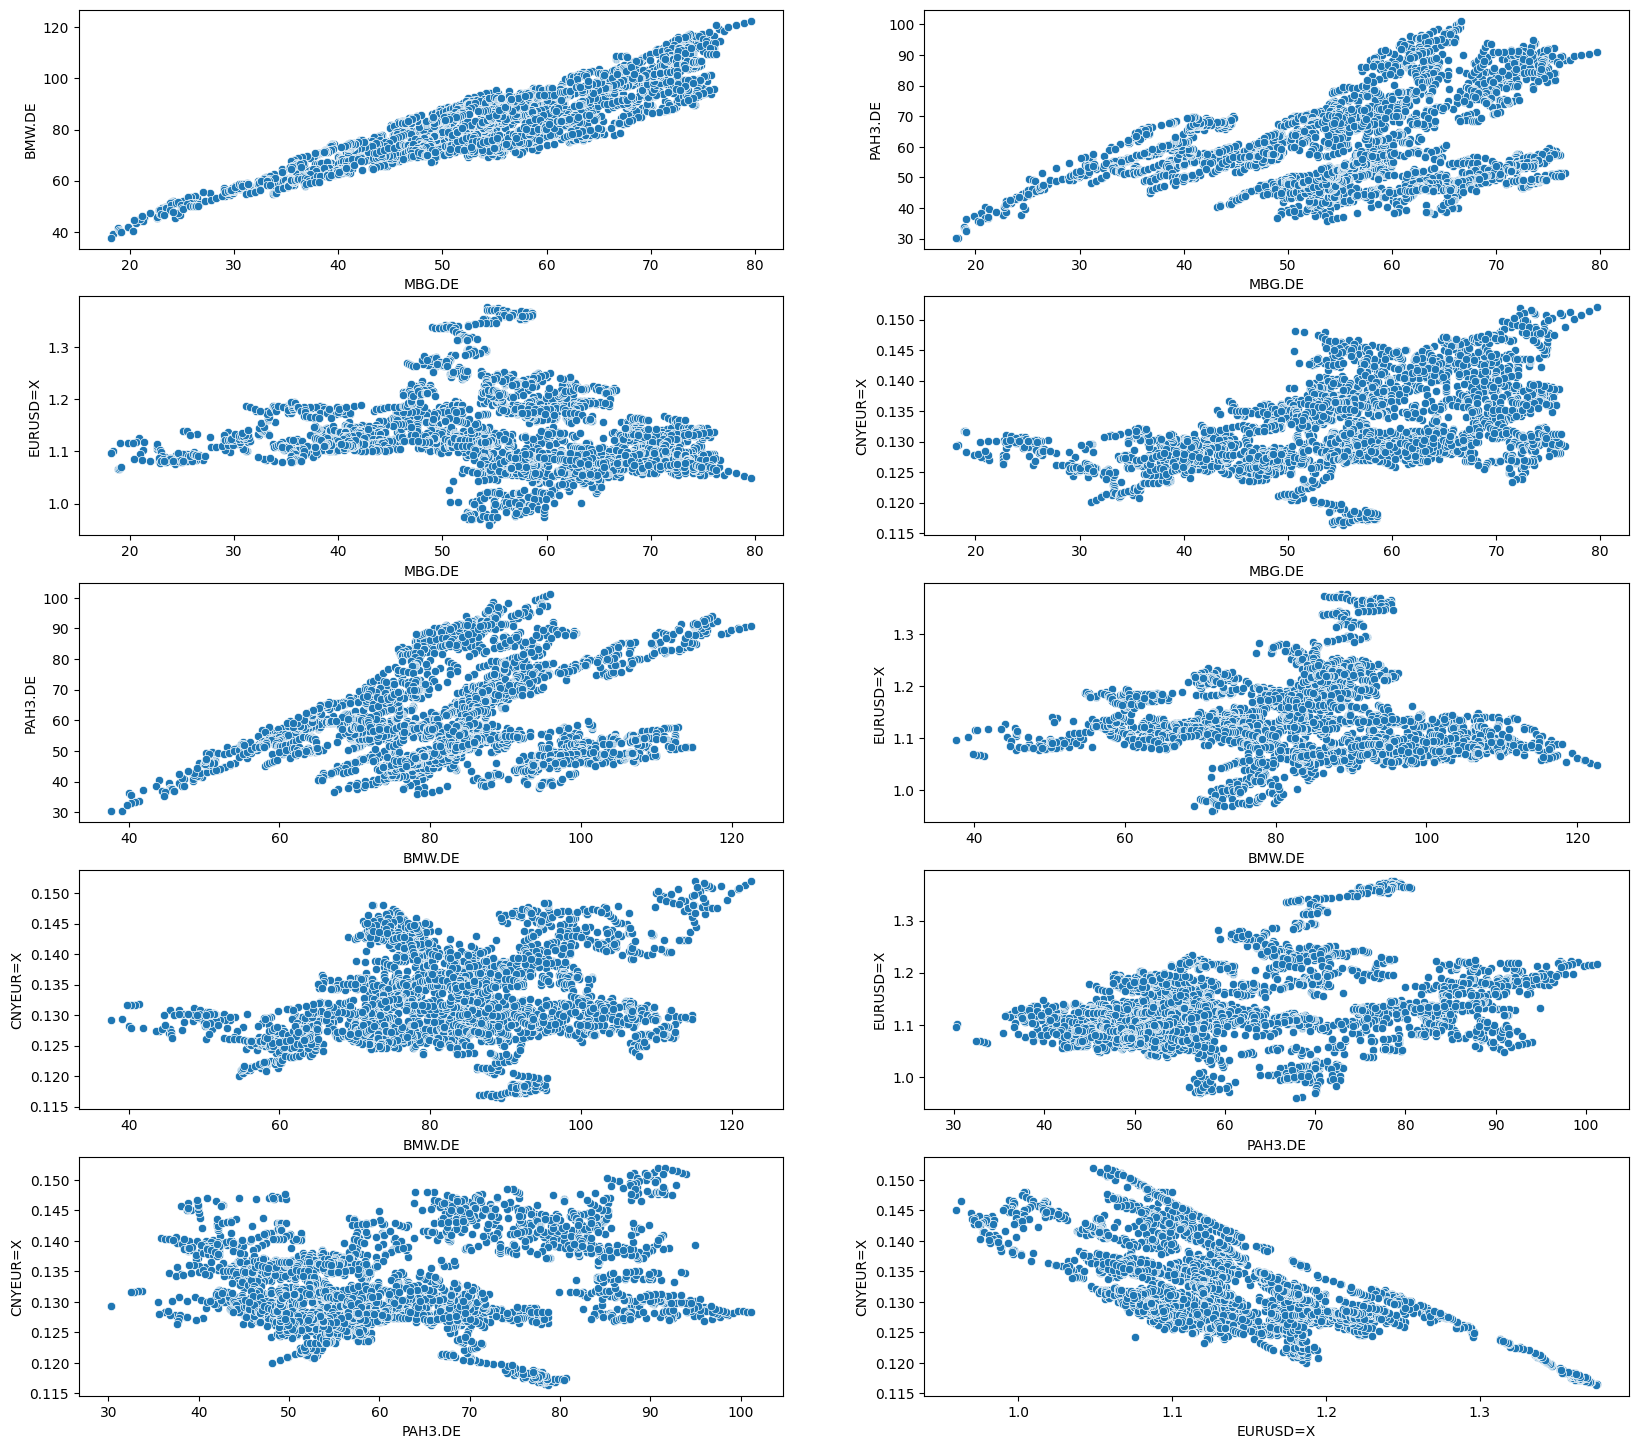

In [66]:
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

combs = list(combinations(tickets, 2))

fig, ax = plt.subplots(5, 2, figsize=(20, 18))

for i, comb in enumerate(combs):

    sns.scatterplot(df, x=comb[0], y=comb[1], ax=ax[i//2][i%2])

> ### **<div style='color:red'> Вывод: </div>**
>
> #### На графиках можно увидеть почти идеальную линейную взаимосвязь между акциями Мерседеса и БМВ, поскольку они считаются мировыми лидерами на рынке авто и поэтому данные компании должны одинаково реагировать на шоки
>
> #### Также можно проследить зависимость между компаниями Порш, Мереседес и БМВ. В целом, это можно объяснить тем, что все данные акции из автомобильной индустрии, поэтому и реагируют одинаково

#### 2.2 (1 балл)
Изобразите гистограмму распределения каждого инструмента, наложив на неё оценённое нормальное распределение. Прокомментируйте характеристики распределения доходностей.

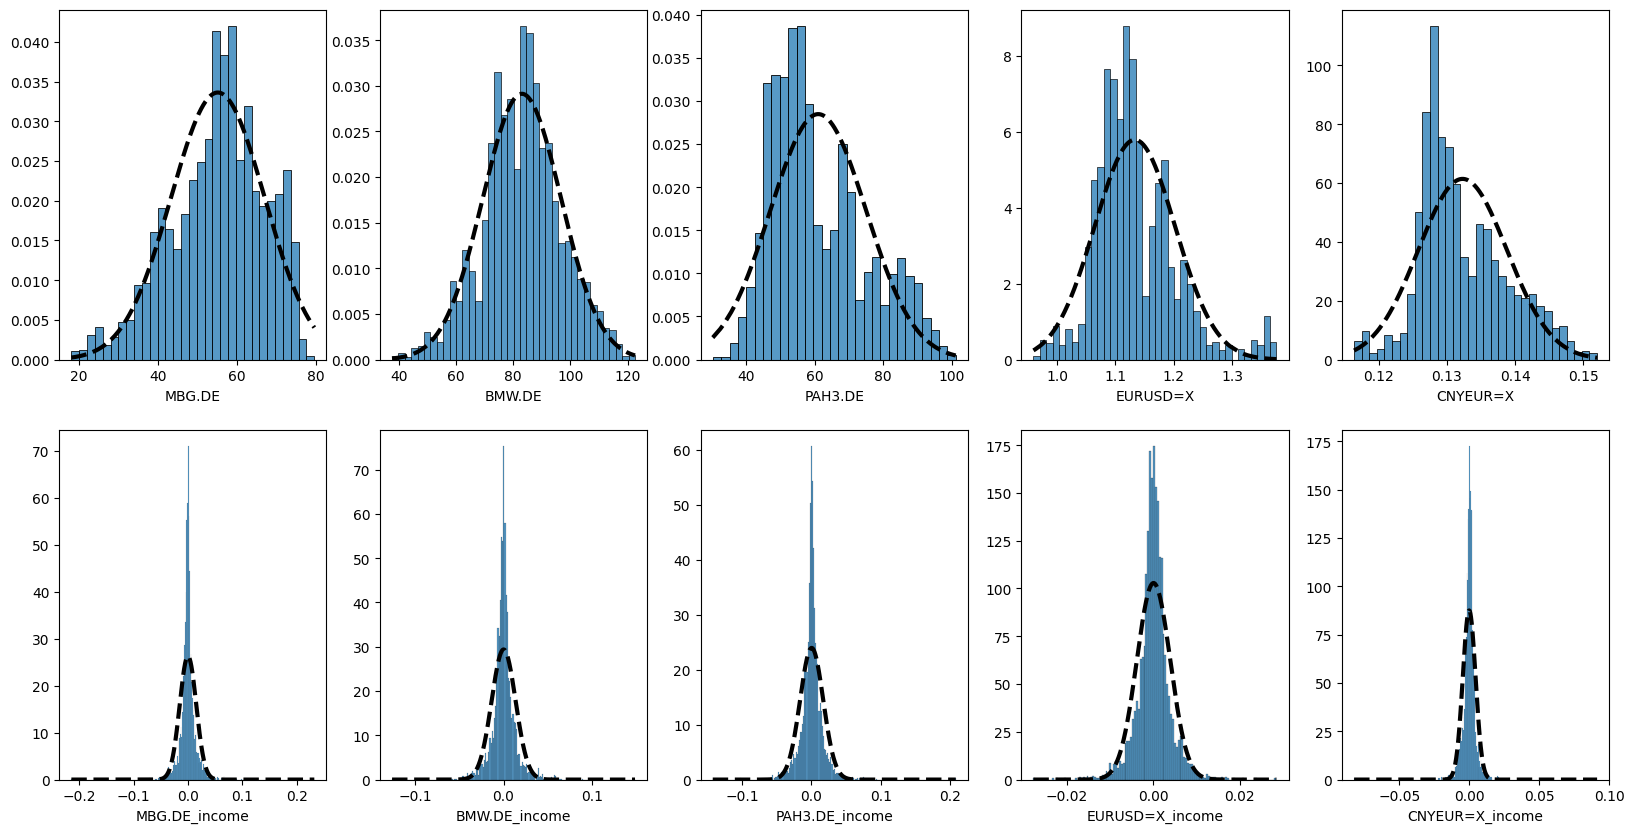

In [67]:
import scipy.stats as sts
import numpy as np

fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i, t in enumerate(tickets + [f'{i}_income' for i in tickets]):

    dt = pd.concat([df, incomes], axis=1)[1:]
    
    sns.histplot(dt, x=t, ax=ax[i//5][i%5], stat='density')


    mean, std = sts.norm.fit(dt[t])
    x_pdf = sts.norm.pdf(np.unique(dt[t]), mean, std)

      
    ax[i//5][i%5].plot(np.unique(dt[t]), x_pdf, '--', linewidth=3, color='black')
    ax[i//5][i%5].set_ylabel('')



> ### **<div style='color:red'> Вывод: </div>**
>
> #### По графикам видно, что распределения доходностей похоже на нормальное, но стоит также подобрать и другие похожие распределения

#### 2.3 (0.5 балла)
В качестве весов портфеля используйте веса на момент покупки (как в семинаре). Изобразите  гистограмму распределения доходностей портфеля, наложив на неё оценённое нормальное распределение. Прокомментируйте характеристики распределения доходностей.

In [68]:
weight = 1 / df.iloc[0].values
weight = weight / weight.sum()

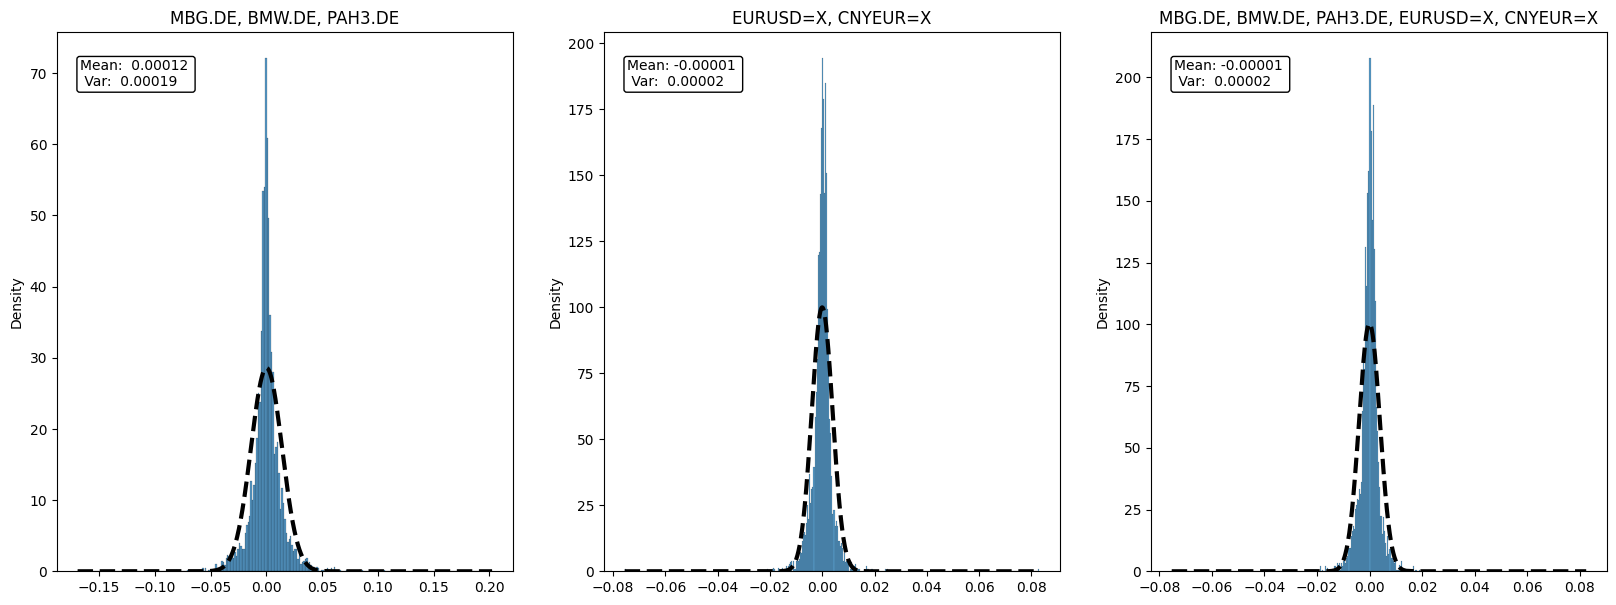

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

features = [df.columns[:3], df.columns[3:], df.columns]

for i, feat in enumerate(features):

    incomes_labels = [f'{i}_income' for i in feat]

    w = 1 / df.iloc[0][feat]
    w = w / w.sum()

    inc = incomes[incomes_labels].values @ w

    sns.histplot(data=inc, ax=ax[i], stat = 'density')
    ax[i].set_title(', '.join(feat))

    x = sts.norm(loc=inc.mean(), 
                 scale=inc.std())
    x_pdf = x.pdf(np.unique(inc))

    outp = f'Mean: {inc.mean(): .5f} \n Var: {inc.std() ** 2: .5f}'

    text = ax[i].text(0.05, 0.95, outp, ha="left", va="top", transform=ax[i].transAxes, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round", pad=0.2))
    
    ax[i].plot(np.unique(inc), x_pdf, '--', linewidth=3, color='black')

> ### **<div style='color:red'> Вывод: </div>**
>
> #### Для любого набора инструментов (только акции, только валюты, все вместе) видно, что распределения похожи на нормальное


#### 2.4 (0.5 балла)
Придумайте, опишите и примените альтернативную стратегию взвешивания. Поясните, почему она имеет смысл.

> ### <div style='color:cyan'> Альтернативная стратегия <div>
>
> #### Я предлагаю взвешивать пересчитывать доли каждого актива в портфеле в начале торгового дня за счет цен открытия. В данном случае можно пренебречь скоростью совершения транзакции или же можно сказать, что за ночь не происходит транзакций и поэтому цена закрытия акции в момент $t$ эквивалентна цене открытия акции в момент $t+1$. Данный метод имеет смысл, поскольку доли каждого из активов будут пересчитываться в соответствии с доходностью: чем больше прибыль у актива $\Rightarrow$ тем б'ольшее его количество в портфеле принесет б'ольшую доходность

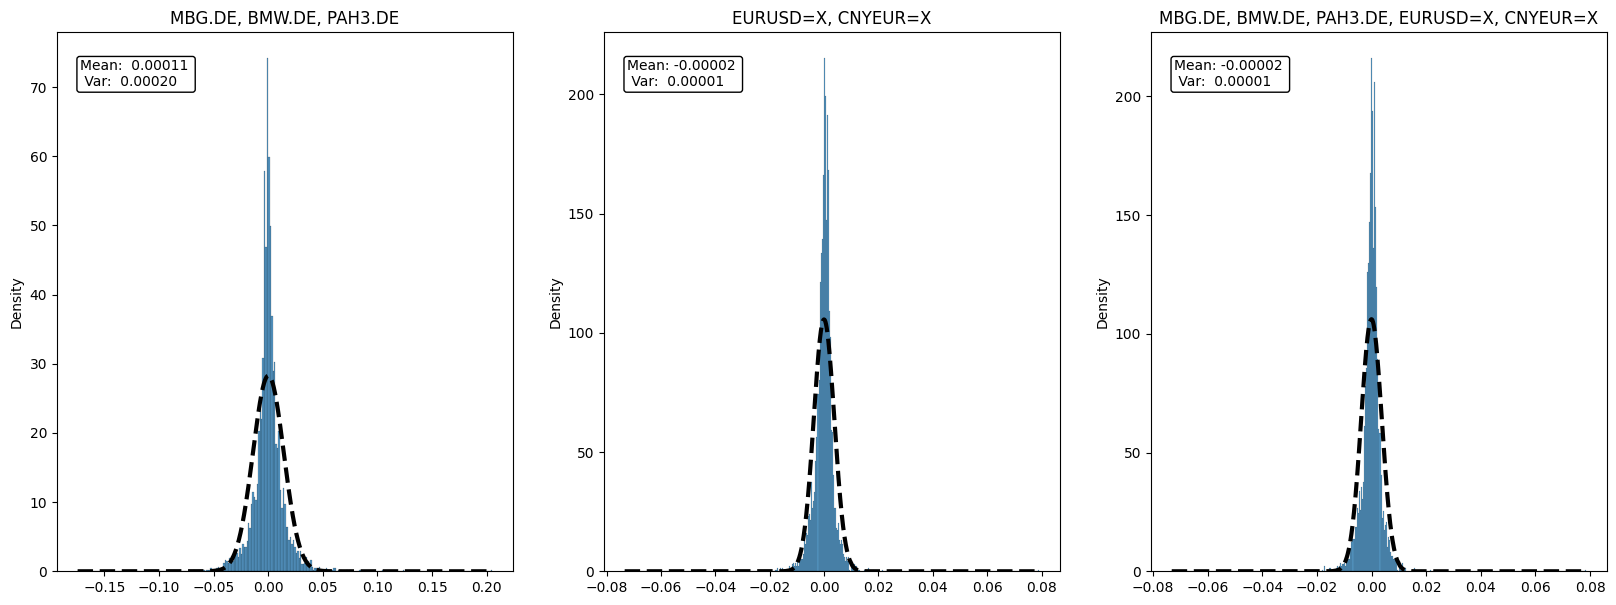

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))

features = [df.columns[:3], df.columns[3:], df.columns]

for i, feat in enumerate(features):

    incomes_labels = [f'{i}_income' for i in feat]

    w = 1 / df_open[feat].values
    w = w / w.sum(axis=1)[:, np.newaxis]

    inc = (incomes[incomes_labels] * w[:-1]).sum(axis=1)

    sns.histplot(data=inc, ax=ax[i], stat = 'density')
    ax[i].set_title(', '.join(feat))

    x = sts.norm(loc=inc.mean(), 
                 scale=inc.std())
    x_pdf = x.pdf(np.unique(inc))

    outp = f'Mean: {inc.mean(): .5f} \n Var: {inc.std() ** 2: .5f}'

    text = ax[i].text(0.05, 0.95, outp, ha="left", va="top", transform=ax[i].transAxes, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round", pad=0.2))

    
    ax[i].plot(np.unique(inc), x_pdf, '--', linewidth=3, color='black')


### 3. Анализ отдельных инструментов. (2 балла, по 0.4 за инструмент)

* Подберите для каждого инструмента наиболее подходящее маржинальное распределение. Можно использовать всё, что есть в scipy, а также garch-модель.
* Для каждого результата изобразите калибровочную кривую (qq-plot), а также наложите оценённую функцию плотности на гистограмму распределения доходности. Прокомментируйте графики.

Обратите внимание, что для GARCH-модели подход будет особенный в плане построения qq-plot и гистограммы. Как мы помним из формулы ниже, дисперсия у нас представлена умножением условной волатильности на распределение. Поэтому на qq-plot и гистограмме нужно будет визуализировать стандартизированные остатки против функции плотности $\epsilon$.

$$r_{t+1} = \mu_t  + \sqrt{h_t}\epsilon_t \text{  with  } \epsilon_t \sim N(0, 1)$$


NB! Постарайтесь подобрать распределение как можно точнее, от этого существенно зависит итоговый результат.


> ### **Распределение Стьюдента**

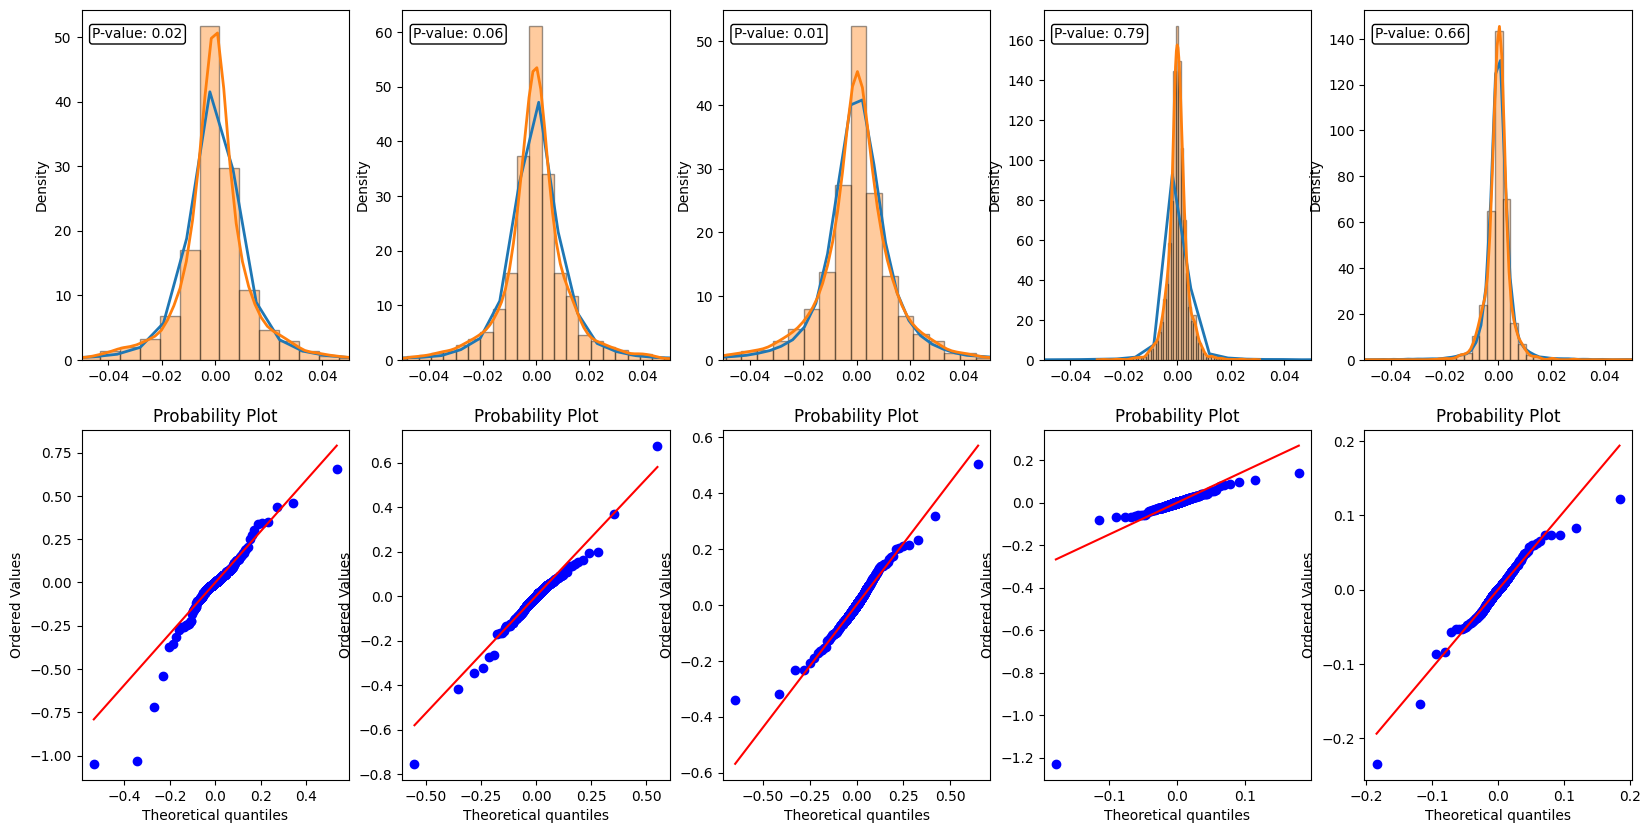

In [71]:
sims = 10 ** 4

sim_t = pd.DataFrame()

params_t = {}

for col in incomes.columns:
    
    t_df, t_mean, t_sigma = sts.t.fit(incomes[col])

    params_t[col] = {'df': int(np.round(t_df)), 'loc':t_mean, 'scale': t_sigma}

    sim_t[col] = sts.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=sims)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i, active in enumerate(dt.columns[5:]):

    sns.distplot(sim_t[active].values, hist=False, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    sns.distplot(incomes[active].values, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    ax[0][i%5].set_xlim(-0.05, 0.05)

    pv = round(sts.ks_2samp(incomes[active].values, sts.t(**params_t[active]).rvs(size=1000)).pvalue, 2)

    text = ax[0][i%5].text(0.04, 0.95, f'P-value: {pv}', ha="left", va="top", transform=ax[0][i%5].transAxes, bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", pad=0.2))


    sts.probplot(sim_t[active].values, plot=ax[1][i%5], dist = sts.t(**params_t[active]));

> ### **Многомерное нормальное распределение**

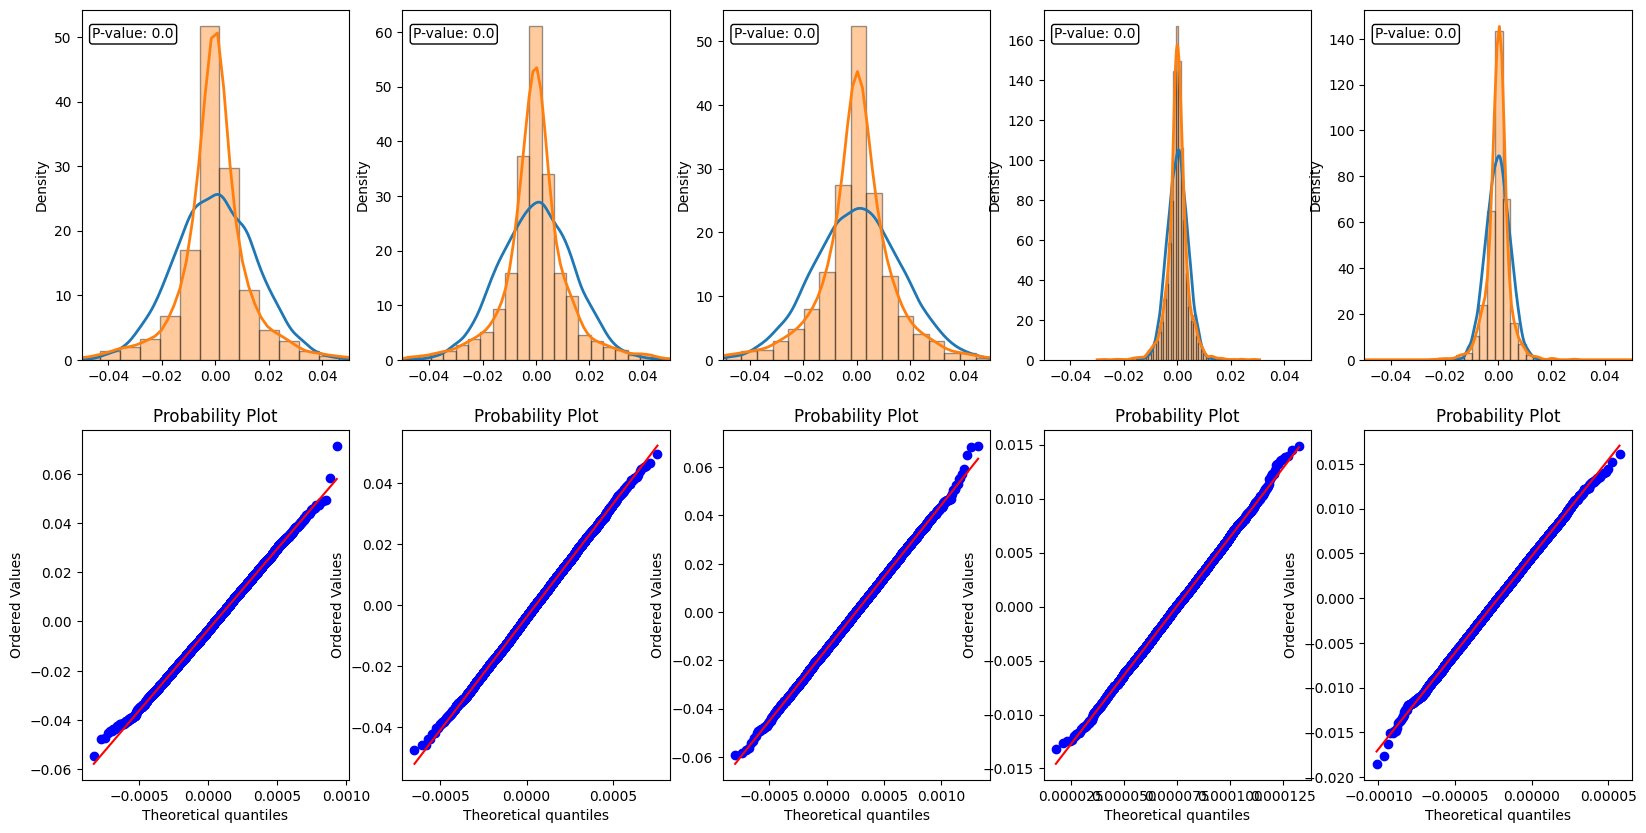

In [72]:
mean = np.mean(incomes.values, axis=0)
cov = np.cov(incomes.values, rowvar=False)

sim_norm = pd.DataFrame(sts.multivariate_normal.rvs(mean=mean, cov=cov, size=sims)).rename(columns={i: f'{df.columns[i]}_income' for i in range(df.shape[1])})

fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i, active in enumerate(dt.columns[5:]):

    sns.distplot(sim_norm[active].values, hist=False, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    sns.distplot(incomes[active].values, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    ax[0][i%5].set_xlim(-0.05, 0.05)

    pv = round(sts.ks_2samp(incomes[active].values, sts.norm(loc = mean[i], scale = np.diag(cov)[i]).rvs(size=1000)).pvalue, 2)

    text = ax[0][i%5].text(0.04, 0.95, f'P-value: {pv}', ha="left", va="top", transform=ax[0][i%5].transAxes, bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", pad=0.2))


    sts.probplot(sim_norm[active].values, plot=ax[1][i%5], dist = sts.norm(loc = mean[i], scale = np.diag(cov)[i]));

> #### **Распределение Гумбеля**

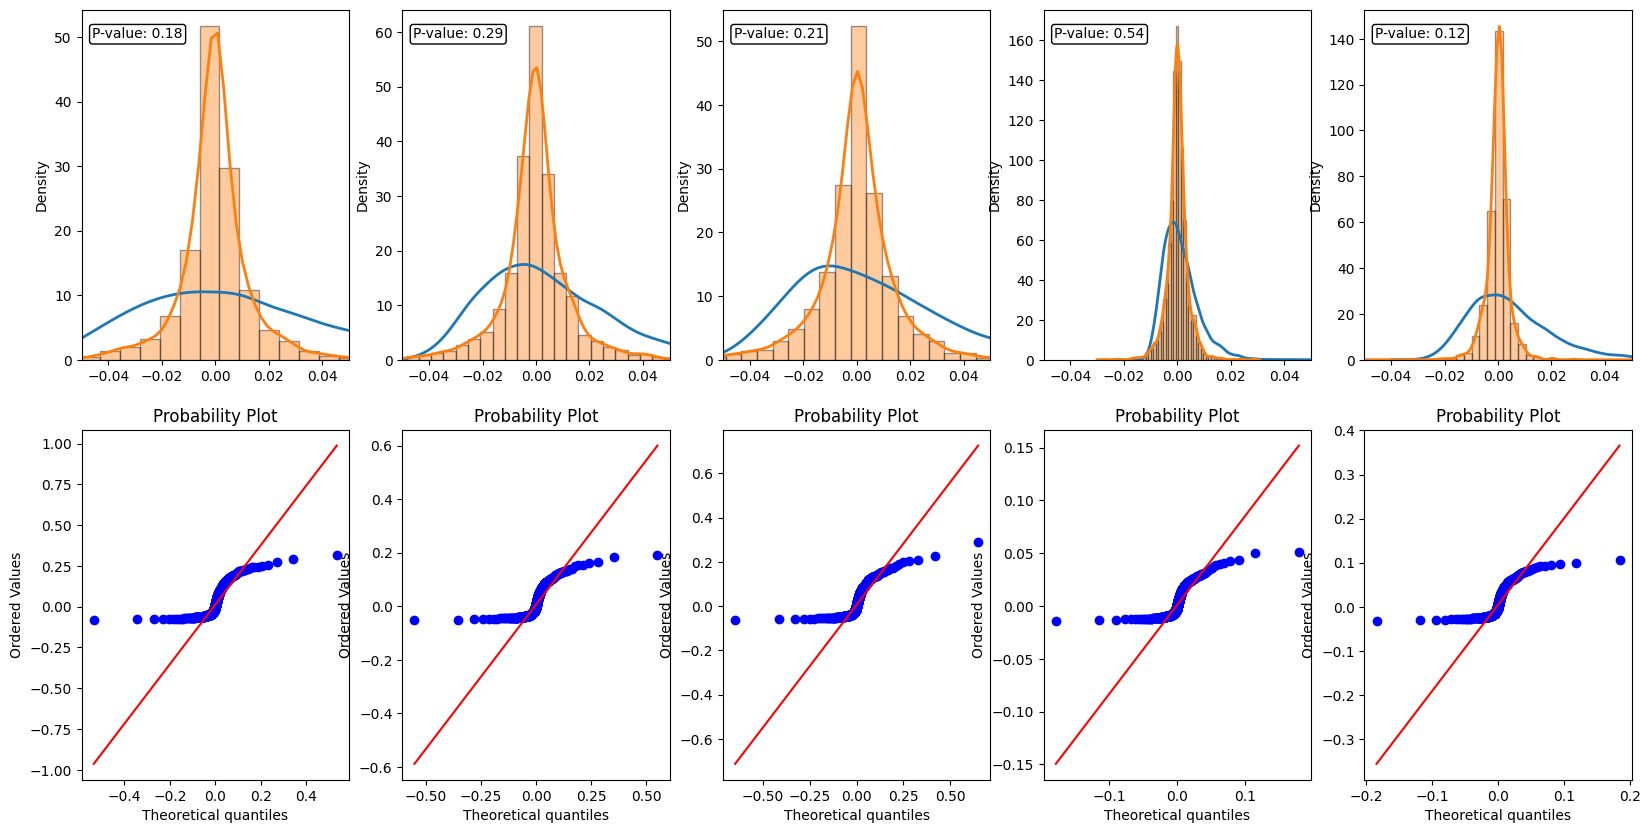

In [73]:
from scipy.stats import gumbel_r

sims = 10 ** 4

sim_gumb = pd.DataFrame()

params_gumb = {}

for col in incomes.columns:
    
    g_loc, g_scale = gumbel_r.fit(incomes[col])

    params_gumb[col] = [g_loc, g_scale]

    sim_gumb[col] = gumbel_r.rvs(loc=g_loc, scale=g_scale, size=sims)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))


for i, active in enumerate(dt.columns[5:]):

    sns.distplot(sim_gumb[active].values, hist=False, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    sns.distplot(incomes[active].values, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    ax[0][i%5].set_xlim(-0.05, 0.05)

    pv = round(sts.ks_2samp(incomes[active].values, sts.t(**params_t[active]).rvs(size=1000)).pvalue, 2)

    text = ax[0][i%5].text(0.04, 0.95, f'P-value: {pv}', ha="left", va="top", transform=ax[0][i%5].transAxes, bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", pad=0.2))


    sts.probplot(sim_gumb[active].values, plot=ax[1][i%5], dist = sts.t(**params_t[active]));


> #### **Распределение Лапласа**

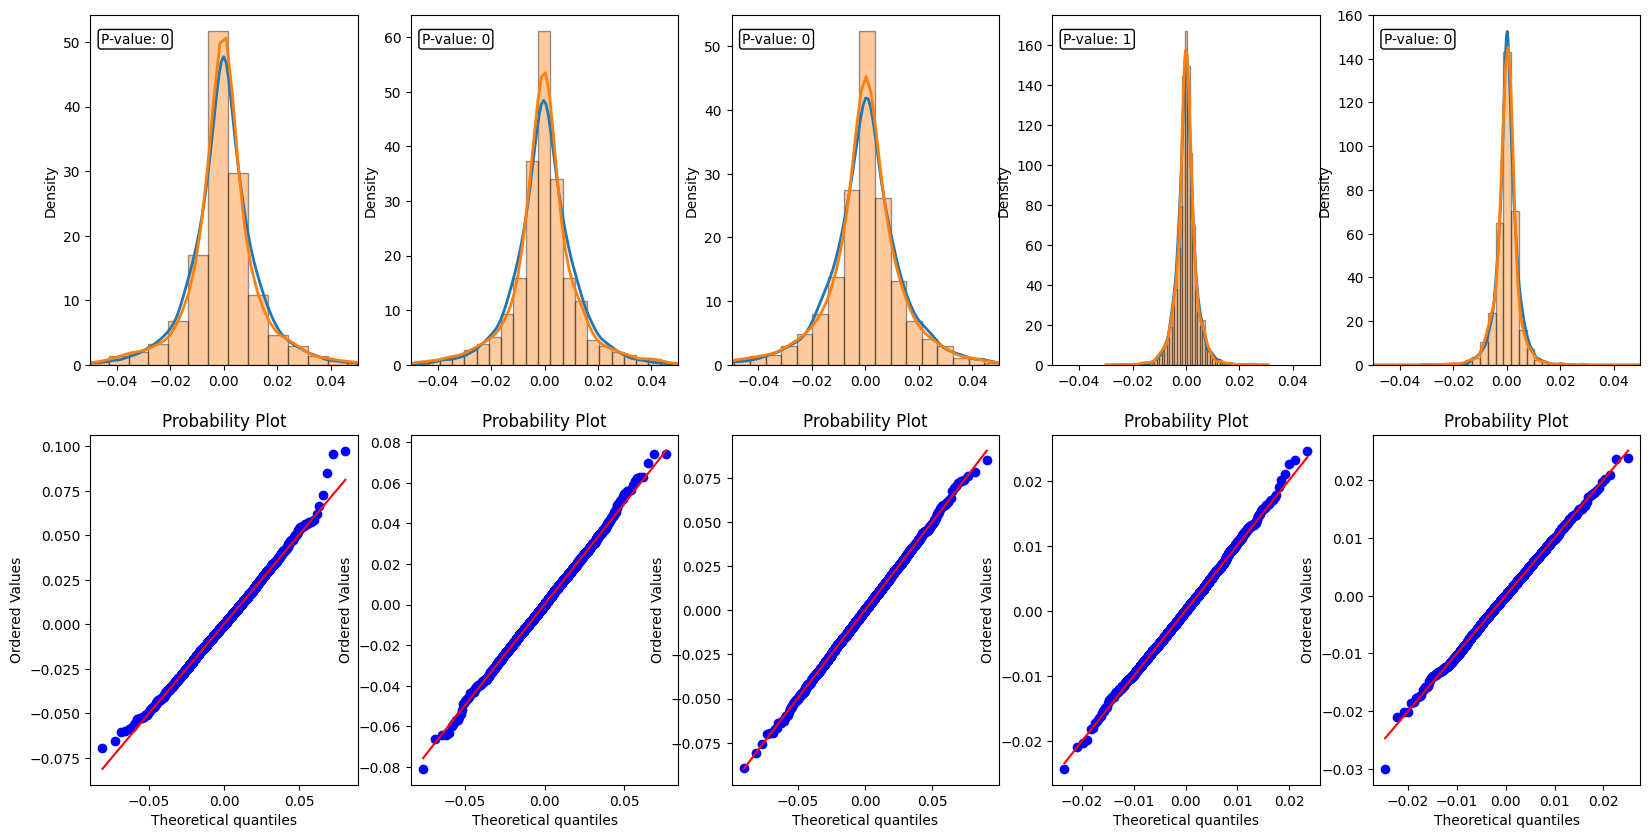

In [74]:
from scipy.stats import laplace

sims = 10 ** 4

sim_lap = pd.DataFrame()

params_lap = {}

for col in incomes.columns:
    
    g_loc, g_scale = laplace.fit(incomes[col])

    params_lap[col] = [g_loc, g_scale]

    sim_lap[col] = laplace.rvs(loc=g_loc, scale=g_scale, size=sims)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))


for i, active in enumerate(dt.columns[5:]):

    sns.distplot(sim_lap[active].values, hist=False, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    sns.distplot(incomes[active].values, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    ax[0][i%5].set_xlim(-0.05, 0.05)

    pv = round(sts.ks_2samp(incomes[active].values, sts.laplace(*params_lap[active]).rvs(size=1000)).pvalue)

    text = ax[0][i%5].text(0.04, 0.95, f'P-value: {pv}', ha="left", va="top", transform=ax[0][i%5].transAxes, bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", pad=0.2))


    sts.probplot(sim_lap[active].values, plot=ax[1][i%5], dist = sts.laplace(*params_lap[active]));


> #### **Распределение Тьюки**

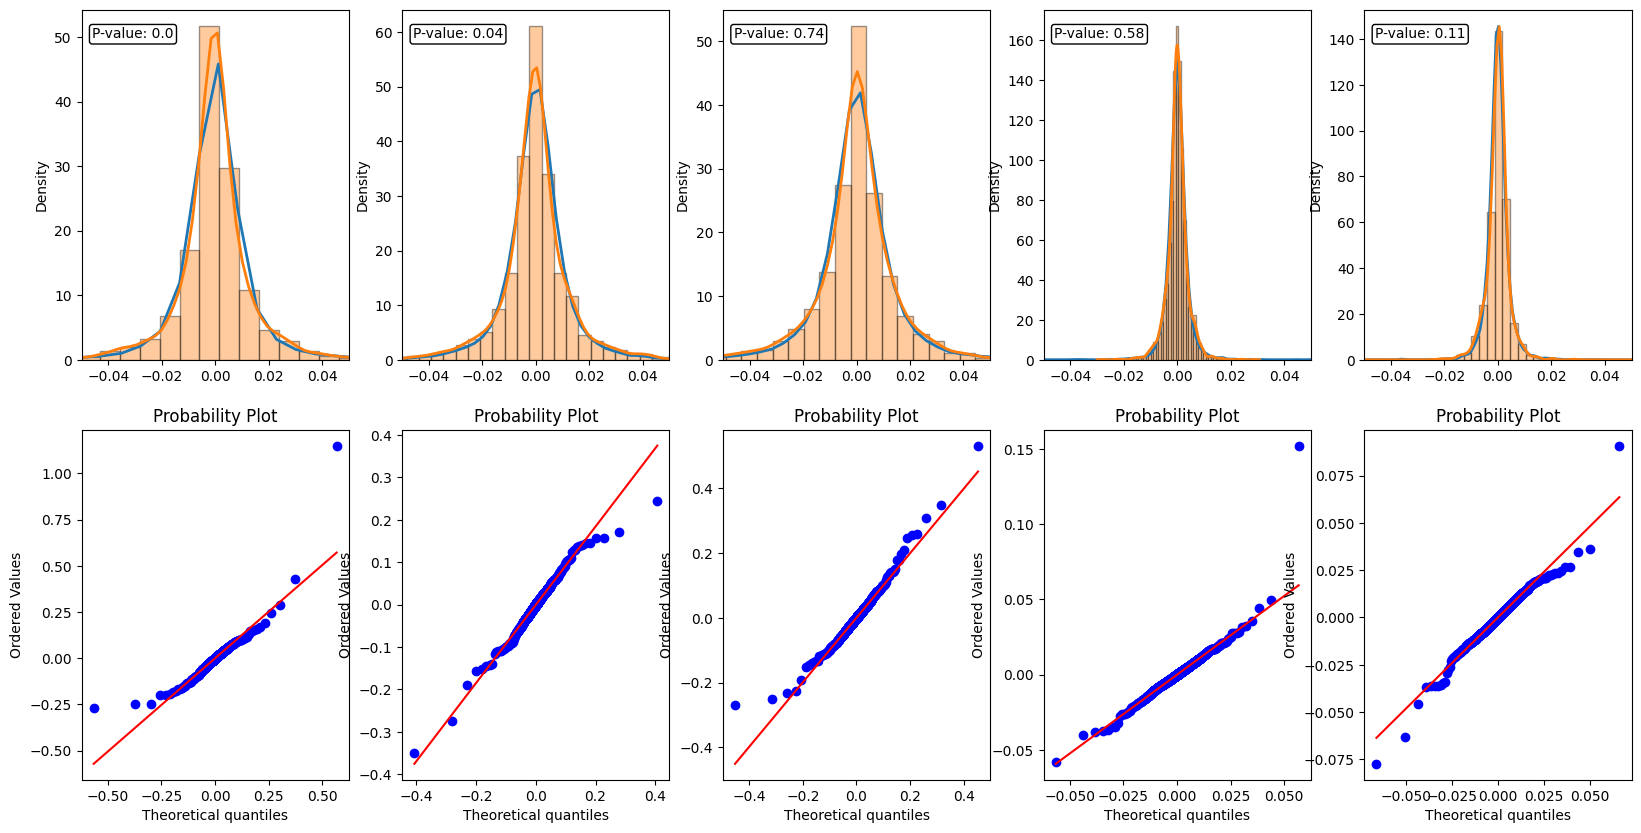

In [75]:
from scipy.stats import tukeylambda

sims = 10 ** 4

sim_tuk = pd.DataFrame()

params_tuk = {}

for col in incomes.columns:
    
    lam, loc, scale = tukeylambda.fit(incomes[col])

    params_tuk[col] = [lam, loc, scale]

    sim_tuk[col] = tukeylambda.rvs(lam = lam, loc=loc, scale=scale, size=sims)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))


for i, active in enumerate(dt.columns[5:]):

    sns.distplot(sim_tuk[active].values, hist=False, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    sns.distplot(incomes[active].values, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    ax[0][i%5].set_xlim(-0.05, 0.05)

    pv = round(sts.ks_2samp(incomes[active].values, sts.tukeylambda(*params_tuk[active]).rvs(size=1000)).pvalue, 2)

    text = ax[0][i%5].text(0.04, 0.95, f'P-value: {pv}', ha="left", va="top", transform=ax[0][i%5].transAxes, bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", pad=0.2))


    sts.probplot(sim_tuk[active].values, plot=ax[1][i%5], dist = sts.tukeylambda(*params_tuk[active]));


> #### **Распределение Джонсон**

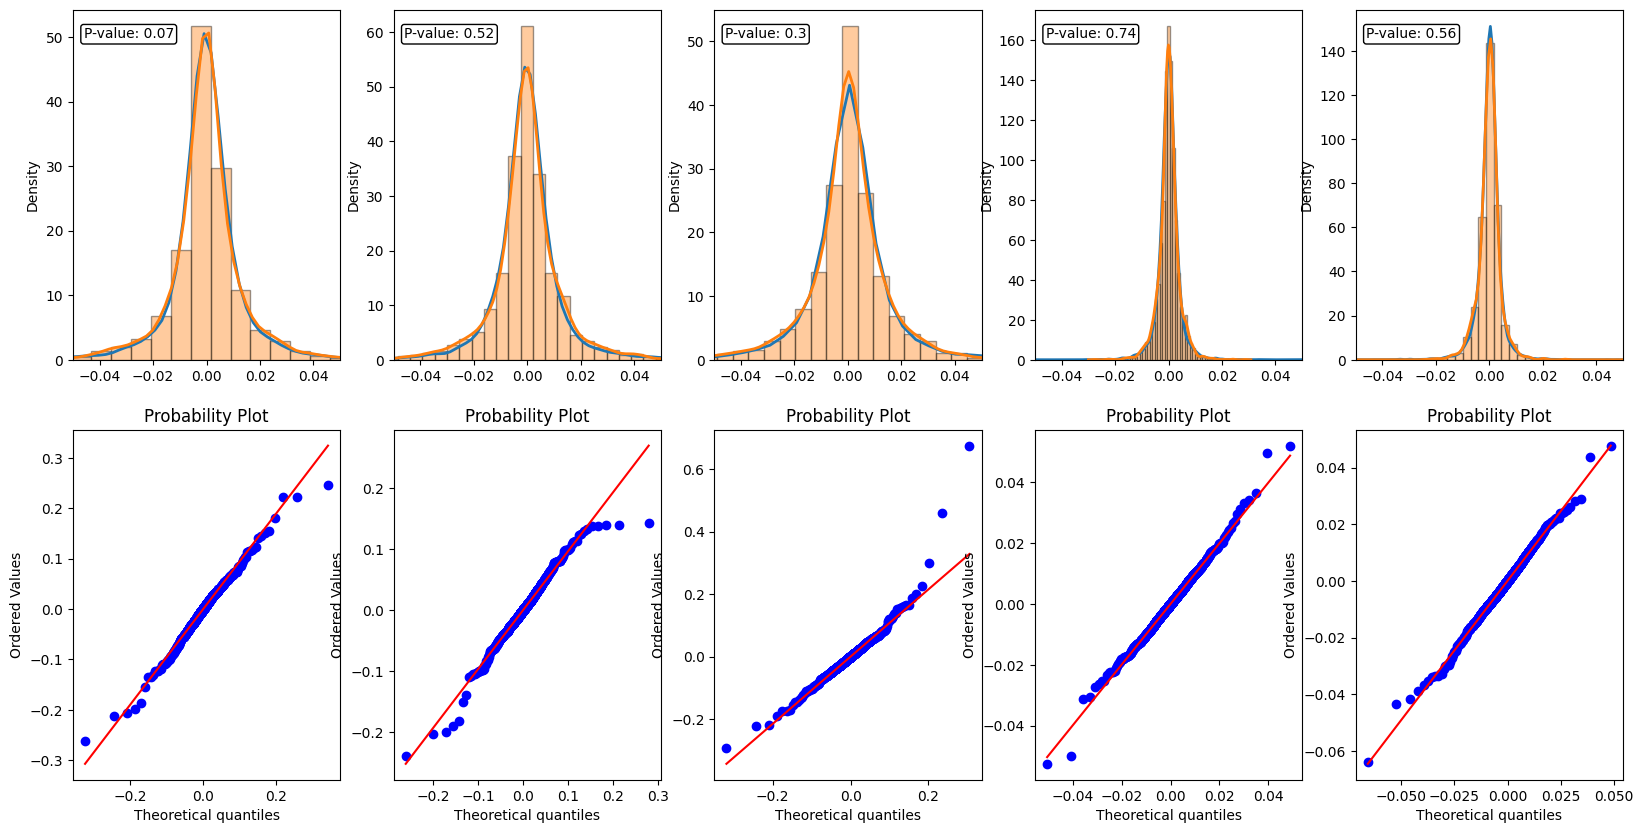

In [76]:
from scipy.stats import johnsonsu

sims = 10 ** 4

sim_j = pd.DataFrame()

params_j = {}

for col in incomes.columns:
    
    a, b, loc, scale = johnsonsu.fit(incomes[col])

    params_j[col] = [a, b, loc, scale]

    sim_j[col] = johnsonsu.rvs(a = a, b = b, loc = loc, scale = scale, size=sims)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))


for i, active in enumerate(dt.columns[5:]):

    sns.distplot(sim_j[active].values, hist=False, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    sns.distplot(incomes[active].values, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0][i%5])

    ax[0][i%5].set_xlim(-0.05, 0.05)

    pv = round(sts.ks_2samp(incomes[active].values, sts.johnsonsu(*params_j[active]).rvs(size=1000)).pvalue, 2)

    text = ax[0][i%5].text(0.04, 0.95, f'P-value: {pv}', ha="left", va="top", transform=ax[0][i%5].transAxes, bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", pad=0.2))


    sts.probplot(sim_j[active].values, plot=ax[1][i%5], dist = sts.johnsonsu(*params_j[active]));


> #### В итоге многомерное нормальное распределение и распределение Лапласа довольно неплохо описывают распределения доходностей, но не совсем понятно какое из низ лучше, поэтому нарисуем распределения доходностей

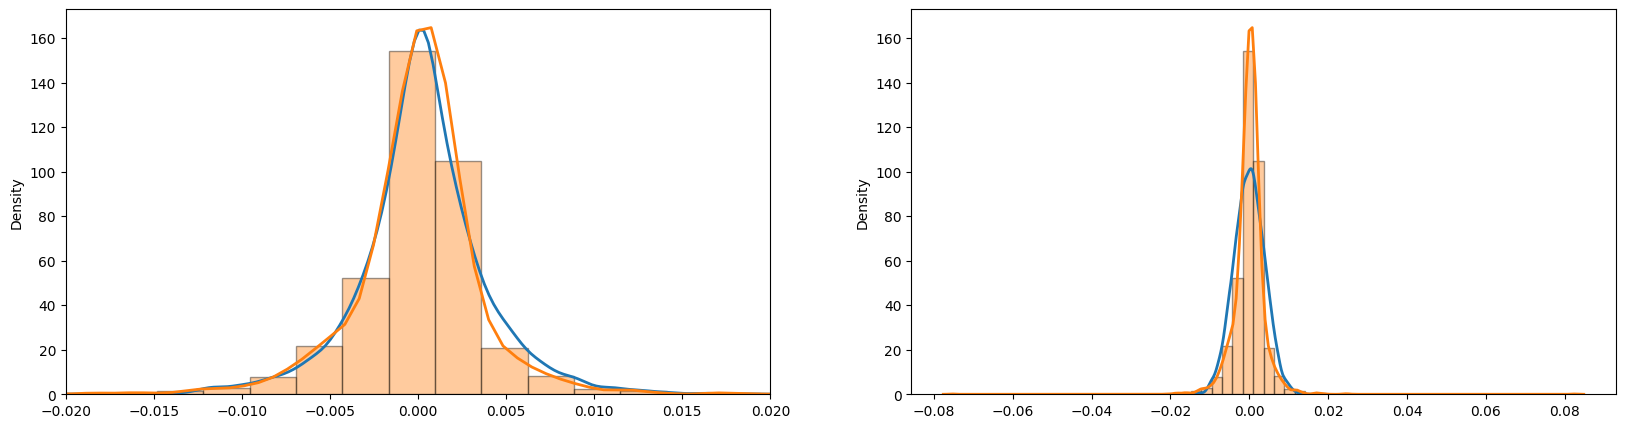

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.distplot(sim_lap.values @ weight, hist=False, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0])

sns.distplot(incomes.values @ weight, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[0])

ax[0].set_xlim(-0.02, 0.02)

sns.distplot(sim_norm.values @ weight, hist=False, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[1])

sns.distplot(incomes.values @ weight, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=ax[1]);

> #### В итоге распределение Лапласа лучше всего описывает доходности как каждого актива, так и всего портфеля в целом. В дальнейшем будем использовать его для всех активов

### 4) Копулы
Мы знаем, что по-отдельности инструменты моделируются довольно легко. Однако так как мы рассматриваем портфель, акции и валюты могут быть скоррелированы. Особенно в случае, когда ваши акции взяты из похожих компаний. Поэтому нам бы хотелось иметь метод, который хорошо учитывает такие зависимости в совокупности. Копулы -- один из таких способов. Ваша последовательность действий будет выглядеть следующим образом:

Пусть мы имеем историю доходностей 5 инструментов за предыдущие 10 лет (условно 365*10 = 3650 наблюдений). Пусть мы хотим сделать прогноз VaR на один шаг вперёд. Представим данные в виде таблицы $3650\times5$

1. Используем найденные в предыдущем пункте распределения. Для каждого из инструментов прогоним доходности через фукнцию распределения. Для GARCH нужно будет предварительно получить стандартизированные остатки, так как распределение оценивается именно для них. Получим вектор той же длины, но уже в диапазоне [0, 1]. Получим таблицу аналогичной размерности, $3650\times5$. По сути, мы переходим в новое признаковое пространство, в котором нам легко оценить и просимулировать распределение с очень сложными зависимостями.

2. Оценим на этой матрице копулу. Выберем наилучшую копулу по AIC.

3. Произведём симуляции из копулы. Так как копула будет иметь размерность 5, то выходная матрица симуляций будет иметь размер $n\_sim\times5$. Ожидается, что компоненты этой симуляции будут коррелированы соответственно исходным данным.

4. Для каждого из пяти инструментов в симуляции проведём обратное преобразование. Для этого используем обратную функцию распределения. Для GARCH нужно будет дополнительно использовать прогнозы матожидания и дисперсии. Получим всё также матрицу $n\_sim\times5$.

5. Далее для подсчёта VaR можно просто взвесить доходности отдельных компонент обратно в портфель и взять от этого квантиль. Для подсчёта ES можно взять математичечкое ожидание доходностей портфеля, которые меньше VaR. Используйте 5%-й VaR.

Используйте одну копулу. Для простоты давайте ограничимся [Архимедовыми копулами](https://copulae.readthedocs.io/en/latest/api_reference/copulae/archimedean/index.html). Они имеют минимум параметров и быстро оцениваются. Не пытайтесь выполнить это задание с эллиптическими копулами (гауссова, стьюдента). Они оцениваются очень долго и вы устанете считать.

Начнём с простого и будем работать со всеми данными сразу. 


#### 4.1 (1 балл)
Проведите преобразование, переводящее доходности на единичный куб. Воспользуйтесь функциями распределения из пункта 4. Опять же, обратите внимание, что GARCH необходимо обрабатывать отдельно и работать с распределением стандартизированных остатков.

In [78]:
cdf_laplace = dt[dt.columns[5:]].copy()

for active in cdf_laplace.columns:

    cdf_laplace.loc[:, active] = sts.laplace(*params_lap[active]).cdf(cdf_laplace[active].values)

cdf_laplace.head()

,MBG.DE_income,BMW.DE_income,PAH3.DE_income,EURUSD=X_income,CNYEUR=X_income
2014-05-13,0.069205,0.190104,0.324747,0.537517,0.661340
2014-05-14,0.328025,0.619219,0.329360,0.860165,0.081825
2014-05-15,0.855202,0.890667,0.771425,0.361914,0.579821
2014-05-16,0.868879,0.948773,0.817244,0.532527,0.480456
2014-05-17,0.319917,0.231276,0.332997,0.542917,0.380197


#### 4.2 (1 балл) 

Используйте пакет [copulae](https://pypi.org/project/copulae/). Подберите по AIC Архимедовы копулы. Выберите одну из двух опций:
1. Выберите лучшую копулу на всех доходностях.  (0.5 балла)
2. Выберите две отдельные копулы. Одна на валюты, одна на акции. (1 балл)


> #### Копулы для всех доходностей

In [79]:
from copulae import ClaytonCopula, GumbelCopula
import warnings


def aic(log_likelihood, num_params):
    aic_value = 2 * num_params - 2 * log_likelihood
    return aic_value

G_1 = GumbelCopula(dim=5).fit(data=cdf_laplace.values, to_pobs=False)
C_1 = ClaytonCopula(dim=5).fit(data=cdf_laplace.values, to_pobs=False)


print(f'ClaytonCopula AIC: {aic(G_1.log_lik(cdf_laplace.values), cdf_laplace.shape[1])}')
print(f'GumbelCopula AIC: {aic(C_1.log_lik(cdf_laplace.values), cdf_laplace.shape[1])}')

ClaytonCopula AIC: -171.8144660588088
GumbelCopula AIC: -889.574042335981


> #### Подбор копулы для валют

In [80]:
G_1 = GumbelCopula(dim=2).fit(data=cdf_laplace[cdf_laplace.columns[3:]].values, to_pobs=False)
C_1 = ClaytonCopula(dim=2).fit(data=cdf_laplace[cdf_laplace.columns[3:]].values, to_pobs=False)


print(f'ClaytonCopula AIC: {aic(G_1.log_lik(cdf_laplace[cdf_laplace.columns[3:]].values), 2)}')
print(f'GumbelCopula AIC: {aic(C_1.log_lik(cdf_laplace[cdf_laplace.columns[3:]].values), 2)}')

ClaytonCopula AIC: 4.0
GumbelCopula AIC: -431.3320547194688


> #### Подбор копулы для акций

In [81]:
G_1 = GumbelCopula(dim=3).fit(data=cdf_laplace[cdf_laplace.columns[:3]].values, to_pobs=False)
C_1 = ClaytonCopula(dim=3).fit(data=cdf_laplace[cdf_laplace.columns[:3]].values, to_pobs=False)


print(f'ClaytonCopula AIC: {aic(G_1.log_lik(cdf_laplace[cdf_laplace.columns[:3]].values), 3)}')
print(f'GumbelCopula AIC: {aic(C_1.log_lik(cdf_laplace[cdf_laplace.columns[:3]].values), 3)}')

ClaytonCopula AIC: -7614.318251802841
GumbelCopula AIC: -6158.456085613645


> #### В итоге для всех доходностей лучше использовать копулу Гумбеля. Что касается копул отдельно для каждого набора инструментов, то для валют лучше использовать копулу Гумбеля, а для акций копулу Клейтона

#### 4.3 (1 балл)
Просимулируйте с помощью копулы ваши инструменты. Для любой пары инструментов нарисуйте четыре scatter-plot в ряд:

1. Исходные доходности
2. Доходности, переведённые на единичный куб
3. Просимулированные доходности на единичном кубе
4. Просимулированные доходности, переведённые в исходные величины

Графики 1/4 и 2/3 должны иметь примерно одинаковые зависимости.

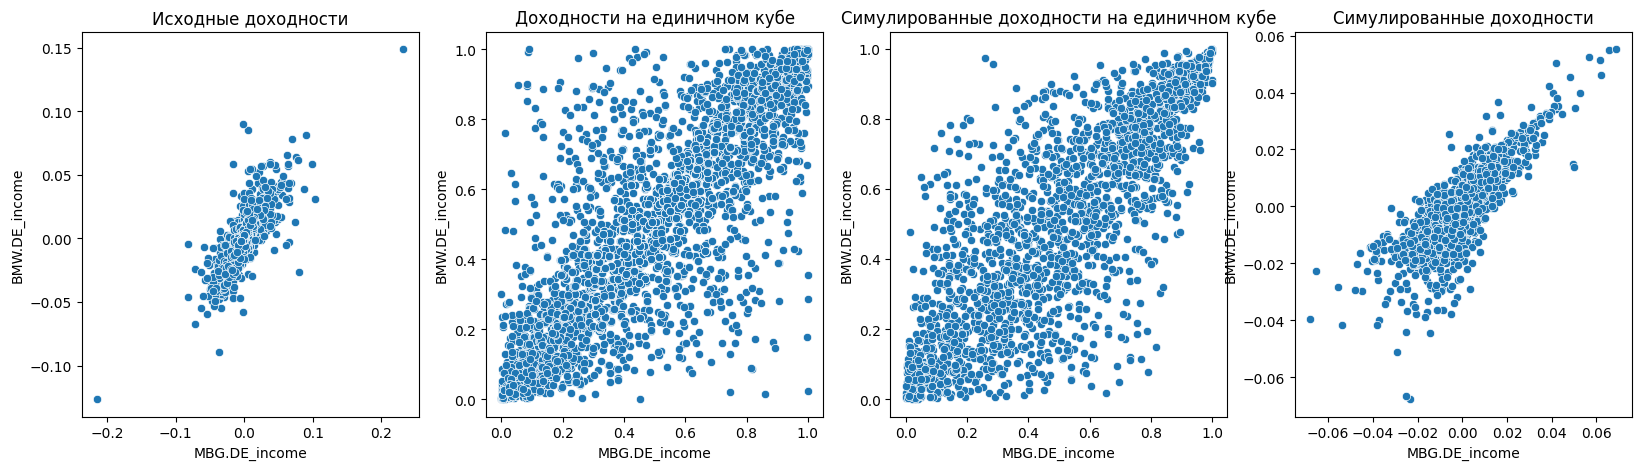

In [82]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sim_nums = 2000

sns.scatterplot(data = dt, x = 'MBG.DE_income', y = 'BMW.DE_income', ax = ax[0])
sns.scatterplot(data = cdf_laplace, x = 'MBG.DE_income', y = 'BMW.DE_income', ax = ax[1])

# sims_4_laplace = pd.DataFrame([sts.laplace(*params_lap[active]).rvs(sim_nums) for active in ['MBG.DE_income', 'BMW.DE_income']]).T.rename(columns = {i: ['MBG.DE_income', 'BMW.DE_income'][i] for i in range(2)})
sims_4_laplace = pd.DataFrame(GumbelCopula(dim=2).fit(data=cdf_laplace[['MBG.DE_income', 'BMW.DE_income']].values, to_pobs=False).random(sim_nums)).rename(columns = {i: ['MBG.DE_income', 'BMW.DE_income'][i] for i in range(2)})
sns.scatterplot(data = sims_4_laplace, x = 'MBG.DE_income', y = 'BMW.DE_income', ax = ax[2])

inv = sims_4_laplace.copy()

for active in sims_4_laplace.columns:

    inv.loc[:, active] = sts.laplace(*params_lap[active]).ppf(sims_4_laplace[active].values)

sns.scatterplot(data = inv, x = 'MBG.DE_income', y = 'BMW.DE_income', ax = ax[3]);

ax[0].set_title('Исходные доходности')
ax[1].set_title('Доходности на единичном кубе')
ax[2].set_title('Симулированные доходности на единичном кубе')
ax[3].set_title('Симулированные доходности');

### 5) VaR и ES (1 балл)

С помощью выбранных распределений и копул вычислите VaR-кривую и ES-кривую. Можно ориентироваться на функцию с семинара 12. Модифицируйте её для подсчёта ES. Если вы использовали альтернативную стратегию взвешивания, также учтите это.

In [83]:
import numpy as np
import pandas as pd 

def calc_VaR(r, sampling_fun, w, L_history=252 * 4, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    ES = np.full(r.shape[0], np.nan)
    
    for i in range(L_history, r.shape[0]):
        history = r[i - L_history: i]

        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)


            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            ES[i] = np.mean(portfolio_simulated_returns[portfolio_simulated_returns < VaR[i]])
            
        except:
            VaR[i] = VaR[i-1]
            ES[i] = ES[i-1]

        
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__)[L_history:], pd.Series(data=ES, index=r.index, name=sampling_fun.__name__)[L_history:]

### 6) Визуализация (0.5 балла)

Визуализируйте VaR и ES на графике с доходностями.

In [84]:
def sampling_func(x, stock = 'MBG.DE_income	BMW.DE_income	PAH3.DE_income'.split('\t'), cur = 'CNYEUR=X_income	EURUSD=X_income'.split('\t')):

    dt_cur = x[cur]
    dt_stock = x[stock]

    params = {}

    for active in stock:

        loc, scale = laplace.fit(dt_stock[active].values)
        params[active] = [loc, scale]
        dt_stock[active] = sts.laplace(loc = loc, scale = scale).cdf(dt_stock[active])

    for active in cur:

        loc, scale = laplace.fit(dt_cur[active])
        params[active] = [loc, scale]
        dt_cur[active] = sts.laplace(loc = loc, scale = scale).cdf(dt_cur[active])

    C_stock = ClaytonCopula(dim=3).fit(data=dt_stock.values, to_pobs=False)
    G_cur = GumbelCopula(dim=2).fit(data=dt_cur.values, to_pobs=False)

    cur_sim = G_cur.random(sim_nums)
    stock_sim = C_stock.random(sim_nums)

    simulations = pd.concat([pd.DataFrame(stock_sim, columns=stock), pd.DataFrame(cur_sim, columns=cur)], axis=1)

    for active in simulations.columns:

        simulations[active] = laplace(*params[active]).ppf(simulations[active])

    return simulations

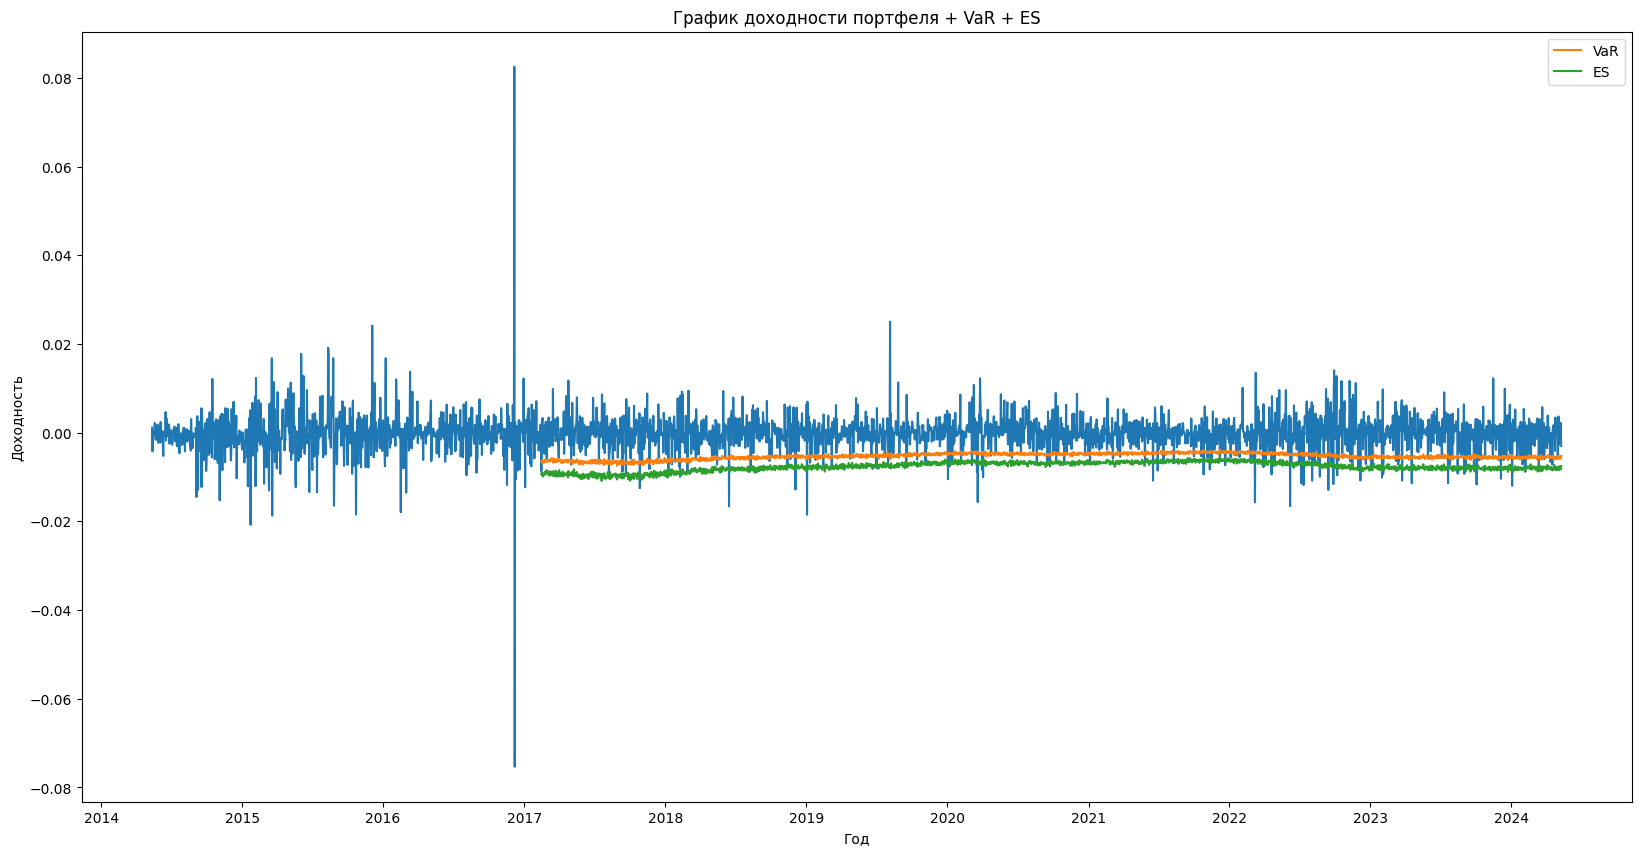

In [88]:
plt.figure(figsize=(20, 10))

plt.plot(incomes @ weight)

for f in [sampling_func]:

    var_es_curve = calc_VaR(dt, sampling_func, weight)

    var = var_es_curve[0]

    es = var_es_curve[1]

    plt.plot(var, label = 'VaR')
    plt.plot(es, label = 'ES')

plt.title('График доходности портфеля + VaR + ES')
plt.ylabel('Доходность')
plt.xlabel('Год')
plt.legend();

### 7) Бектестинг. (1 балл)

Проведите тесты на покрытие и независимость для VAR-кривой. Добейтесь того, чтобы тесты успешно проходились, без этого пункт не засчитывается. Если потребуется, вернитесь к подбору частных распределений.

In [90]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(52)

def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))

def backtest_results(ret, var_curve, alpha, significance=0.99):
    
    idx = var_curve.notna().index
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < sts.chi2.ppf(significance, 1)

    independence = ind_test(violations) < sts.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')

    otp1, otp2 = False, False
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')

        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')


backtest_results(incomes @ weight, var_es_curve[0], 0.05)

Target share of violations: 5.00%
Observed share of violations: 5.98%

Test for coverage is passed

Test for independence is passed


##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7